# Bayesian Learning Assignment 2

MSc DSAI Quentin Le Roux

<hr>
<hr>
<hr>

## Library Imports

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import norm, uniform, binom
from scipy.stats import multivariate_normal
from sklearn import datasets 

<hr>

## Function declarations

**Note**: 
- *Functions are listed per exercise in alphabetical orders*
- *Functions are provided with Type Hinting*

### Exercise 1 functions

In [54]:
def beta_binomial_distribution(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the beta-binomial distribution over the space of 
    parameter theta, given the parameters alpha, beta, y, and n.
    """
    # Declares a linear space for the parameter theta
    theta_space  = np.linspace(0,1)
    # Computes and return the distribution
    distribution = theta_space**(y+alpha-1) * \
                   (1-theta_space)**(n+beta-y-1)
    return theta_space, distribution

def beta_binomial_lapproximation(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the Laplace approximation of the beta binomial
    distribution (a Gaussian distribution) with parameters
    derived from the original distribution's parameters alpha,
    beta, y, and n.
    """
    theta_max = (y+alpha-1)/(n+alpha+beta-2)
    hessian   = -(y+alpha-1)/(theta_max**2) - \
                (n+beta-y-1)/((1-theta_max)**2)
    variance  = -1/hessian
    return norm(theta_max, np.sqrt(variance))

### Exercise 4 functions

*Some functions will be reused in exercise 5*.

In [200]:
def evaluate_log_post(
    params: list, 
    other_params: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used for performing a Laplace
    approximation.
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom
    }
    #Computes the log-priors
    log_prior = np.sum([models[model[0]].logpdf(params[i], *model[1]) 
                        for i, model in enumerate(priors)])         
    # Guarantees positive variance in the Gaussian case
    if likelihood == "gaussian": params[-1] = np.abs(params[-1])
    # Checks for the other set of parameters
    if len(other_params) > 0: params = (params, other_params)
    # Computes the log-likelihood
    log_likelihood = np.sum([models[likelihood].logpdf(point, *params) 
                             for point in data])
    return - (log_likelihood + log_prior)

def evaluate_log_post_regression(
    params: list, 
    var_names: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used for performing a Laplace approximation
    as part of a linear regression process.
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom
    }
    #Computes the log-priors
    log_prior = np.sum([models[model[0]].logpdf(params[i], *model[1]) 
                        for i, model in enumerate(priors)])   
    #Evaluating expression
    target, predictors = var_names[0], var_names[1]
    # Computes the Gaussian parameters
    mu = np.ones(len(data[predictors[0]])) * params[0]
    for i in range(len(predictors)):
        mu += params[i+1] * data[predictors[i]].values
    sigma = np.abs(params[-1])
    # Computes the log-likelihood
    t = data[target].values
    N = len(t)
    log_lik = np.sum([models["gaussian"].logpdf(t[i], mu[i], sigma) 
                      for i in range(N)])
    return -(log_lik + log_prior)

def laplace_solution(
    params:list,
    other_params: list,
    data: pd.Series,
    likelihood: str,
    priors:list
) -> list:
    """
    Computes a Laplace approximation of a distribution given sets of
    prior and likelihood parameters.
    """    
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post, params,  
        args = (other_params, data, likelihood, priors), 
        method = "BFGS"
    )
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def laplace_solution_regression(
    expression: str, 
    data: pd.DataFrame, 
    likelihood: str, 
    priors: list
) -> list:
    """
    Computes a Laplace approximation for a regression given sets
    of priors and likelihood parameters
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom
    }
    # Parses the linear regression expression
    collapsed_expression = expression.replace(" ", "")
    target, independent = collapsed_expression.split("~") 
    independent = independent.split("+")
    var_names = [target, independent]
    # Computes the random variates for each prior
    params = [models[priors[i][0]].rvs(*priors[i][1]) 
              for i in range(len(priors))]
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post_regression, params, 
        args = (var_names, data, likelihood, priors), 
        method = "BFGS"
    )
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def plot_relationship(
    x: pd.Series, y: pd.Series,
    xlabel: str, ylabel:str,
    title: str
) -> None:
    """
    Plots the 2D plot of the relationship between two variables.
    """
    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show

def plot_variation(
    data: pd.DataFrame,
    depvar_name: str,
    covar_mean: list,
    covar_name: str,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str,
    posterior_samples: np.ndarray,
    higher_order: bool = False,
    max_order: int = 1
):
    """
    Plots the predictive regression of a dataset.
    """
    # Computes the range of the plot area
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = post_mean[0] + post_mean[1] * x_range + post_mean[2] * x_range**2
    mean_prediction = post_mean[0] + \
                      np.sum([post_mean[i] * x_range**(i if higher_order else 1) 
                              for i in range(1, max_order+1)],
                             axis=0)
    # Samples from a posterior distribution to obtain a predictive interval for
    prediction_range = [
        posterior_samples[:,0] + \
        np.sum([posterior_samples[:,i] * _x**(i if higher_order else 1)
        for i in range(1, max_order+1)], axis=0)
        for _x in x_range
    ]
    prediction_range_noise = [
        norm.rvs(prediction, posterior_samples[:,-1]) 
        for prediction in prediction_range
    ]
    # Plots the base of the counterfactual graph
    n = posterior_samples.shape[0]
    plt.plot(x_range + covar_mean, mean_prediction, lw=2, color="black")
    plt.scatter(data[covar_name] + covar_mean, data[depvar_name])
    plt.title(plot_title)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    # Plotting the uncertainty
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, prediction_range_noise[i], alpha = 0.05, color = 'grey')
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, prediction_range[i], alpha = 0.05, color = 'green')
    
def posterior_sampling_laplace(
    solution: list, 
    n_samples: int
) -> list:
    """
    Computes a sampling of a posterior distribution
    yielded from a Laplace approximation.
    """
    posterior_samples = multivariate_normal.rvs(
        solution[0], solution[1], size = n_samples
    )
    return posterior_samples
    
def sampling_from_posterior(
    data: pd.DataFrame, 
    mean_covariate: float, 
    depvar_name: str, 
    covar_name: str, 
    posterior_samples: multivariate_normal.rvs,
    posterior_means: list,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str
) -> None:
    """
    Samples datapoints from a posterior distribution and plots the resulting
    distribution.
    """
    # Samples from the posterior
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = posterior_means[0] + posterior_means[1] * x_range
    for i in range(1000):
        prediction = posterior_samples[i,0] + posterior_samples[i,1] * x_range
        plt.plot(x_range + mean_covariate, prediction, lw = 0.05, color = 'grey')
    # Plots the resulting plot
    plt.scatter(data[covar_name] + mean_covariate, data[depvar_name])
    plt.plot(x_range + mean_covariate, mean_prediction, lw = 2, color = 'black')
    plt.title(plot_title)
    plt.ylabel(plot_ylabel)
    plt.xlabel(plot_xlabel)
    plt.show()

def summarize(
    solution: list, 
    names: dict={0:'a',1:'b', 2:'sigma'}, 
    plot: bool=False
) -> tuple:
    """
    Summarizes the regression statistics obtained via a
    Laplace approximation.
    """
    # Computes posterior samples
    posterior_samples = posterior_sampling_laplace(
        solution, 1000
    )
    #### Computes summary stats
    #    85% confidence interval
    post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
    #    standard deviation
    post_sd = np.std(posterior_samples, axis = 0)
    #     mean
    post_mean = np.mean(posterior_samples, axis = 0)
    # Prints the results
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.rename(index=names, inplace=True)
    print(summary_stats)
    # If requested, prints the plot of the posterior data
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()
    # Returns the posterior samples
    return post_mean, post_sd, posterior_samples

### Exercise 5 functions

*Exercise 5 reuses functions from exercise 4*.

In [56]:
def posterior_plot_univariate_regression(
    solution: list, 
    x_range: np.ndarray, 
    data: pd.DataFrame, 
    center: int = 0, 
    names: list = ['x','y'], 
    n_samples: int = 500
):
    """
    Plots the univariate regression plot of a sampling of a
    posterior distribution computed with a Laplace approximation.
    """
    # Samples from the posterior distribution obtained via
    # Laplace approximation to obtains data statistics
    post_samples = posterior_sampling_laplace(solution, n_samples)
    degree = post_samples.shape[1] - 1
    post_mean = np.mean(post_samples, axis = 0)
    mean_prediction = np.zeros(len(x_range)) + \
                      sum([post_mean[i] * x_range**i for i in range(degree)])
    # Plots the results of the sampling
    plt.plot(x_range + center, mean_prediction, lw = 2, color = 'black')
    plt.title('regression result')
    plt.ylabel(names[1])
    plt.xlabel(names[0])
    list_model_samples = []
    # Samples from the posterior to get a predictive interval
    for n in range(n_samples):
        mod_sample = np.zeros(len(x_range))
        for i in range(degree):
            mod_sample += post_samples[n,i] * x_range**i
        list_model_samples.append(mod_sample)
    prediction_noise = []
    for i,mod_sample in enumerate(list_model_samples):
        prediction_noise.append(norm.rvs( mod_sample, post_samples[i,-1]))  
    # Plots the uncertainty
    for i in range(n_samples): 
        plt.scatter(x_range + center, prediction_noise[i], alpha = 0.05, color = 'grey')
        plt.scatter(x_range + center, list_model_samples[i], alpha = 0.05, color = 'green')
    plt.scatter( data[names[0]] + center, data[names[1]])

### Exercise 6 functions

<hr>
<hr>
<hr>

## Exercise 1

### Instructions

The Beta-Binomial model seen during lesson 2 is:

$$p(y|\theta)p(\theta) \propto \theta^{y+\alpha-1}(1-\theta)^{n+\beta-y-1} \propto Beta(\theta|\alpha+y,n+\beta-y).$$

Find a Laplace approximation for this model, as seen for the Binomal model, and plot the resulting Gaussian approximation against the Beta-Binomial function.

<hr>

#### 1. Finding the Laplace approximation of the Beta-Binomial model

We recall that the Laplace method approximate the shape of a given function through the application of a Gaussian distribution. This approximation relies on the Taylor expansion of the (log-)function of interest *f*. *f* is the function to approximate. We declare the function *g* such that:

$$f(x) = \exp(\log(f(\theta)) = \exp(g(\theta))$$

Stopping at the second order, and assuming that *g* and *f* share a maximum in $\theta_0$, we can approximate *g* and thus *f* for any point $theta$ sufficiently close to $\theta_0$ such that:

\begin{align}
g(\theta) &= g(\theta_0) + g'(\theta_0)(\theta-\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2 + o((\theta - \theta_0)^3)\\
g'(\theta_0) = 0 \\
\end{align}

We find the following approximation:

\begin{align}
g(\theta) &\approx g(\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\\
f(\theta_0) &\approx f(\theta_0) + \exp(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2) \\
&\approx \exp\big(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\big)\quad\text{Given $f(\theta_0)$ a constant}\\
&\approx \exp\big(-\frac{1}{2}\frac{(\theta-\theta_0)^2}{-\frac{1}{g''(\theta_0)}}\big)\quad\text{We recognize a Gaussian PDF}\\
\end{align}

As such, *f* can be approximated (up to a normalization constant) by a Gaussian distribution $\mathcal{N}(\theta_0, -\frac{1}{g''(\theta_0)})$

<u>Computing the maximum of the log-distribution:</u>

\begin{align}
g(\theta) & = \log(f(\theta)) = (y+\alpha-1)*\log(\theta) + (n+\beta-y-1)*\log(1-\theta)\\
\frac{\delta g}{\delta \theta} &= \frac{y+\alpha-1}{\theta} - \frac{n+\beta-y-1}{1-\theta}
\end{align}

As such:

\begin{align}
g'(\theta_0) &= 0\\
&\Rightarrow \frac{y+\alpha-1}{\theta_0} - \frac{n+\beta-y-1}{1-\theta_0} = 0\\
&\Rightarrow \frac{(1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1)}{\theta_0(1-\theta_0)} = 0\\
&\Rightarrow (1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1) = 0 \\
&\Rightarrow (2-n-\alpha-\beta)*\theta_0 +y+\alpha-1 = 0
\end{align}

We find:

$$\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$$

<u>Computing the second derivative of the log-distribution with respect to $\theta$:</u>

\begin{align}
\frac{\delta^2 g}{\delta \theta^2} &= -\frac{y+\alpha-1}{\theta^2} - \frac{n+\beta-y-1}{(1-\theta)^2}
\end{align}

We find:

$$g''(\theta_0) = -\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2}$$

<u>Concluding on finding the Laplace approximation of the Beta-Binomial model:</u>

The approximation will be the Gaussian:

$$\mathcal{N}\big(\frac{y+\alpha-1}{n + \alpha + \beta - 2}, -(-\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}\big)$$

with mean $\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$ and variance $\sigma^2=(\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} + \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}$

#### 2. Plotting the approximation

For plotting the resulting approximation, we will reuse the values for $\alpha$, $\beta$, $n$, and $y$ from class 5.

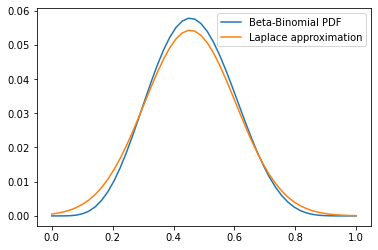

In [57]:
# Variable declarations

y = 4; n = 8; alpha = 2; beta = 3

# Computing the beta-binomial PDF
theta_space, beta_binomial = beta_binomial_distribution(n, y, alpha, beta)

# computing the beta-binomia approximation
lapproximation = beta_binomial_lapproximation(n, y, alpha, beta)

# Plotting the results

plt.figure()
plt.plot(
    theta_space, 
    beta_binomial/np.sum(beta_binomial), 
    label="Beta-Binomial PDF")
plt.plot(
    theta_space,
    lapproximation.pdf(theta_space)/np.sum(lapproximation.pdf(theta_space)),
    label="Laplace approximation")
plt.legend()
plt.show()

<hr>
<hr>
<hr>

## Exercise 2

### Instructions

Write down a model to evaluate the claim: *Animal diversity is related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

<hr>

#### 1. Problem statement

From [wikipedia](https://en.wikipedia.org/wiki/Latitude), "*latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface. Latitude is an angle (defined below) which ranges from 0° at the Equator to 90° (North or South) at the poles*." 

Common sense can lead us to assume that animal diversity is closely correlated to location (here, latitude). Furthermore, given prior belief, we may suppose that the most inhospitable areas in the world are located towards the poles, while the most hospitable would be closer to the equator (e.g. Amazonian Forest, Subsaharan Africa, etc.). Furthermore, since a biome is constituted by both fauna and flora, we can suppose that animal and plant diversity are correlated.

As a caveat, this modeling is not without blind spots as areas such that the Sahara desert might influence the average diversity of a locale/latitude, as we are not interested in longitude as a parameter.

Finally, given these assumptions, we may hypothesize that:

- Any metric related to latitude would display some symmetric behavior with regards to the distance from the equator.
- The closer to the poles, i.e. the farther from the equator, the lower biome diversity is
    - Animal diversity and plant diversity are related
    - Diversity decreases with latitude.

**Note:** Assuming any metric of animal diversity cannot be negative (at worse it would be zero), we could imagine a diversity metric as following a Poisson distribution at a given latitude.

<u>Possible example of a diversity metric per latitude given our assumptions:</u>

Represented on a graph with the x-axis the distance from the equator, and on the y-axis a metric evaluating animal diversity, we would expect a possibly linear, decreasing dataset of a form.

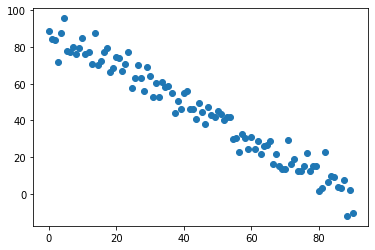

In [58]:
x = np.linspace(0, 90, num=100)
y = sorted(np.linspace(0, 90, num=100), reverse=True) + \
    np.random.normal(0, 5, 100)
plt.scatter(x, y); plt.show()

#### 2. Model definition

As such, since we are interested in a possible relationship between latitude and animal diversity, but we also want to account/control for plant diversity, we could defined a preliminary model as a linear regression with `animal diversity` as the dependent variable and `latitude` and `plant diversity` as its covariates. 

We are interested in the regression function $r$ such that:

$$r \rightarrow \mathbb{E}[animal\,diversity\,\,|\,\,latitude,\,\, plant\,diversity]$$

This results in the following possibly linear relationship:

\begin{align}
\text{animal diversity} &= a+b*\text{latitude} + c*\text{plant diversity}\\\\
\text{with,}\\
a&,\text{ the intercept}\\
b, c&,\text{ resp. covariates of latitude and plant diversity}
\end{align}

<hr>
<hr>
<hr>

## Exercise 3

### Instructions

Invent your own example of spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

<hr>

#### 1. Example of spurious correlation

From [Investopedia](https://www.investopedia.com/terms/s/spurious_correlation.asp), "*a spurious correlation (or spuriousness) refers to a connection between two variables that appears to be causal but is not. With spurious correlation, any observed dependencies between variables are merely due to chance or are both related to some unseen confounder.*"

An example could be the following:

> The sale of foie-gras is spuriously correlated to the sale of umbrellas in the Alpes-Maritimes, France.

If at face value it is obvious that the two variables are not causally linked, they are correlated through the underlying variable of seasonality -- the [rainiest months in the Alpes-Maritimes are during the months of October, November and December](https://en.wikipedia.org/wiki/Nice#Climate). Furthermore, foie-gras sales are [closely tied to the Christmas and New Year holidays](https://www.businesscoot.com/fr/etude/le-marche-du-foie-gras-france).

As such, we have a situation where the sale of foie-gras, being our dependent variable, should be correlated to both predictor variables: season/month of the year, and sales of umbrellas. Given a model where both covariates are included, we would expect the predictive aspect of the sales of umbrellas to decrease or disappear.

<hr>
<hr>
<hr>

## Exercise 4

### Instructions

The attached data is about observations of urban foxes in human habitat. The data has 5 columns:

- *group*: Number of social group the fox belongs to
- *avgfood*: The avg amount of food available in the territory
- *groupsize*: The number of foxes in the social group
- *area*: Size of the territory
- *weight*: Body weight of the fox

Fit a regression for *weight* as a linear function of *area*, and a regression for *weight* as a linear function of *groupsize*. What can you say about these relationships? Run a multivariate model and plot counterfactual plots for both variables. What can you conclude about this analysis?

<hr>

#### 1. Data import and exploration

In [179]:
data = pd.read_csv("data.csv")
data.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


[Text(0.5, 1.0, "Distribution of urban foxes' weight")]

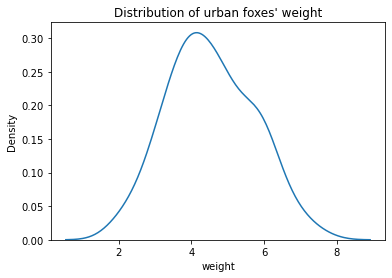

In [180]:
sns.kdeplot(data["weight"]).set(title="Distribution of urban foxes' weight")

[Text(0.5, 1.0, "Distribution of urban foxes' area")]

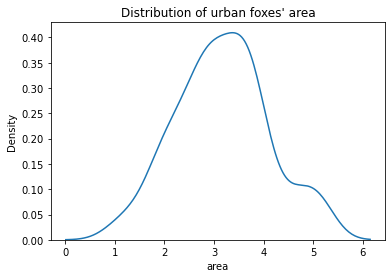

In [181]:
sns.kdeplot(data["area"]).set(title="Distribution of urban foxes' area")

[Text(0.5, 1.0, "Distribution of urban foxes' groupsize")]

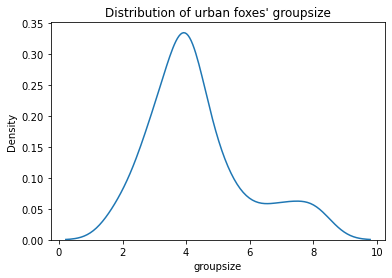

In [182]:
sns.kdeplot(data["groupsize"]).set(title="Distribution of urban foxes' groupsize")

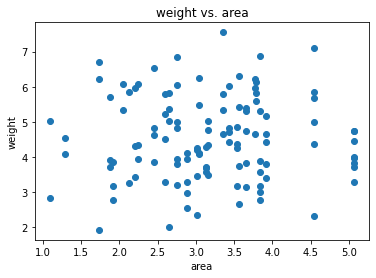

In [183]:
x, y, title= ("area", "weight", "weight vs. area")
plot_relationship(data[x], data[y], x, y, title)

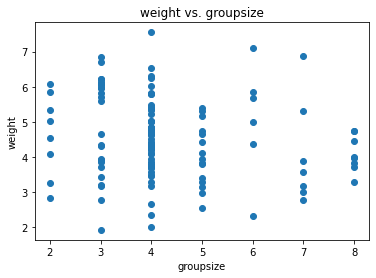

In [184]:
x, y, title= ("groupsize", "weight", "weight vs. groupsize")
plot_relationship(data[x], data[y], x, y, title)

#### 3. Estimating a model of `weight` sampling from prior mean and variance

<u>Selecting priors:</u>

We start by fitting a model for the variable `weight` only. Given the observed sample distribution, we can weakly assume that `weight` is Gaussian-distributed. `weight` is the result of infinitesimal accumulations of mass/growth during the life span (such as with the variable `height` seen in class).

Therefore, for each fox $i$, we may assume that their `weight` is distributed as: $\quad\text{weight}_i\sim N(\mu,\sigma^2)$.

As we can consider foxes as being fungible individuals, we can also state independence between each observation such that:

$$p(\text{weight}) = p(\text{weight}_1, \text{weight}_2, \ldots, \text{weight}_N) = p(\text{weight}_1).p(\text{weight}_2)\cdots p(\text{weight}_N)$$

This corresponds to a product of Gaussian likelihoods. Once set on using a Gaussian likelihood, we look into specifing a prior. We can use a Gaussian model encoding our belief by assuming:

\begin{align}
\mu_{prior} &\sim\,\,\mathcal{N}(4.5,3)\\
\sigma_{prior} &\sim\,\,\mathcal{U}(0,2)
\end{align}

**Interpretation**: The average weight of an urban fox is 4.5 kilograms with a $2\sigma$-variability of $[0.9kg, 8.1kg]$, which seem reasonable as we are including the whole fox population, from pups to the largest individuals. For the variance, we don't have a clear opinion on the matter and we can simply say that it is uniformly distributed on the interval $[0kg, 2kg]$.

<u>Integrating data in the model and obtaining its posterior:</u>

We specify our likelihood:

\begin{align}
p(y|\mu,\sigma^2) &= N(y|\mu,\sigma^2)\\\\
\text{with}&\,\\
y&,\,\,\text{the weight data}
\end{align}

<u>Using Laplace approximation:</u>

Because a grid method is computationally inefficient, and because we need to perform inference on $\sigma$ as well (which makes us reject using the closed form of the Gaussian), we use the Laplace approximation in order to yield a model of `weight`. As such, we rely on **Laplace approximation** to compute a Gaussian approximation of the model.

\begin{align}
P(\mu, \sigma|h_i, a, b, \mu_0, \sigma_0) &\approx P(h_i|\mu,\sigma).p(\mu, \sigma|a,b,\mu_0, \sigma_0)\\
&\approx \mathcal{N}([\mu^*, \sigma^*], \Sigma)\\
\end{align}

We rely on the optimizer offered by the SciPy library to perform our approximation:

In [185]:
# Declares the likelihood with the sample parameters
likelihood = "gaussian"; mu=4.53; sigma=1.18 #4.53, 1.18
parameters = [mu, sigma]

# Defines the prior mean
prior_mu_mean = 4.5; prior_mu_sigma = 3
prior_mu = ["gaussian", [prior_mu_mean, prior_mu_sigma]]

# Defines the prior sigma
sigma_inf = 0.; sigma_sup = 2.
prior_sigma = ["uniform", [sigma_inf, sigma_sup]]

# Performs the optimization
solution = laplace_solution(parameters, [], data["weight"], likelihood, [prior_mu, prior_sigma])

      fun: 186.399890424752
 hess_inv: array([[1.19675967e-02, 4.41943897e-06],
       [4.41943897e-06, 5.99152106e-03]])
      jac: array([-5.7220459e-06,  0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([4.5296157 , 1.17890797])


The variable `solution` contains both the distribution of the mean and covariance of the posterior of `weight`, i.e., the parameters $\mu$ and $\sigma$. As such, we explore this new model of `weight`:

In [186]:
posterior_samples = posterior_sampling_laplace(solution, 1000)
print(f"The mean of the `weight` parameters are: {posterior_samples.mean(axis=0)}.")
print(f"The standard deviation of the `weight` parameters are: {posterior_samples.std(axis=0)}.")
print(f"\nThe 85% quantile bounds for the `weight` parameters are:\n",
      np.quantile(posterior_samples, q=[0.075, 0.925], axis=0))

The mean of the `weight` parameters are: [4.52837638 1.17823902].
The standard deviation of the `weight` parameters are: [0.11185496 0.07823329].

The 85% quantile bounds for the `weight` parameters are:
 [[4.36503074 1.06394689]
 [4.68783408 1.29105465]]


#### 3. Performing a regression with `weight` as a linear function of `area`

Now that we explored in detail the urban foxes' `weight`, we can finally study the relationship bwetween `weight` and `area`. As such, we are interested in the relationship: 

$$\text{weight} = a + b * \text{area}$$

The intercept $a$ expresses the `weight` of an urban fox when its `area` territory area is null (which could represent transient foxes, pups, etc.) while the slope $b$ indicates how much the mass of a fox changes with the size of its territory.

From now on, we will assume that our previous Gaussian model of `weight` (seen above) is dependent on the variable `area` through this linear relationship. The rationale would be that a larger territory would grant a fox more hunting area and thus preys to grow. In this case, the `weight` of an urban fox is a sample from a Gaussian distribution:

$$\text{weight}_i\sim \mathcal{N}(\mu_i,\sigma^2)$$

Along with this distribution, we state that:

$$\mu_i = a + b * \text{area}_i$$

i.e., the mean $\mu_i$ varies depending on area size, the coefficient $a$ and $b$ as well as the noise $\sigma$, assumed to be the same across subjects.

To finally define our Bayesian model, we specify priors for all the parameters we want to analyze:

\begin{align}
p(a) &= \mathcal{N}(4.5, 1.2)\tag{Based on our previous modeling of `weight`}\\
p(b) &= \mathcal{N}(3, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

<u>Centering the data:</u>

We center the `area` variable to avoid scale effects.

In [187]:
# Centers the data
mean_area = data["area"].mean()
centered_data = data.copy()
centered_data["area"] -= mean_area

<u>Performing the Laplace regression:</u>

In [188]:
# Declares the regression expression
expression = "weight ~ area"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 4.5; prior_a_sigma = 1.2
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 3.; prior_b_sigma = 1.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(expression, centered_data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 190.7453573766247
 hess_inv: array([[ 0.01157455, -0.00017572, -0.0001728 ],
       [-0.00017572,  0.01376204,  0.00032917],
       [-0.0001728 ,  0.00032917,  0.00607285]])
      jac: array([3.81469727e-06, 5.72204590e-06, 7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 10
     njev: 16
   status: 0
  success: True
        x: array([4.52941034, 0.06601136, 1.17929856])


<u>Summarizing the computed statistics:</u>

In [189]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution)

           mean        SD      7.5%     92.5%
a      4.525841  0.104282  4.374818  4.680849
b      0.061570  0.116629 -0.107219  0.231709
sigma  1.179279  0.078301  1.067599  1.294806


<u>Plotting the results with sampling from the posterior:</u>

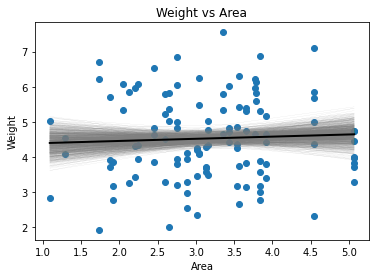

In [190]:
sampling_from_posterior(
    centered_data, mean_area, 
    "weight", "area", 
    posterior_samples, posterior_means,
    "Weight vs Area", "Area", "Weight"
)

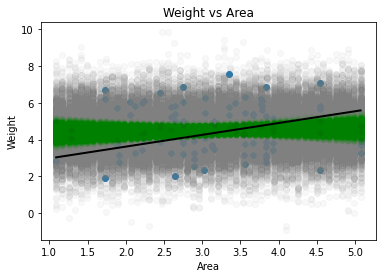

In [191]:
counterfactual_plot(
    centered_data,
    "weight",
    mean_area,
    "area",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples,
    higher_order = False,
    max_order = 1
)

#### 4. Performing a regression with `weight` as a linear function of `groupsize`

We reproduce the same workflow as with the variable `area` but swapping the prior distribution parameters of the slope $b$ such that:

$$p(b)=\mathcal{N}(4., 4.)$$

<u>Centering the data:</u>

We center the `groupsize` variable to avoid scale effects.

In [167]:
# Centers the data
mean_groupsize = data["groupsize"].mean()
centered_data["groupsize"] -= mean_groupsize

<u>Performing the Laplace regression:</u>

In [193]:
# Declares the regression expression
expression = "weight ~ groupsize"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 4.5; prior_a_sigma = 1.2
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 4.; prior_b_sigma = 4.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(expression, centered_data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 186.89927404811553
 hess_inv: array([[ 1.09190716e-01, -2.23115112e-02, -4.36866052e-04],
       [-2.23115112e-02,  5.06899906e-03,  8.90032042e-05],
       [-4.36866052e-04,  8.90032042e-05,  5.65360196e-03]])
      jac: array([ 3.81469727e-06,  1.90734863e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 115
      nit: 20
     njev: 28
   status: 0
  success: True
        x: array([ 5.02400097, -0.1147556 ,  1.16362167])


<u>Summarizing the computed statistics:</u>

In [194]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution)

           mean        SD      7.5%     92.5%
a      5.010454  0.329066  4.554318  5.515975
b     -0.110824  0.070290 -0.211198 -0.013713
sigma  1.163876  0.075961  1.059744  1.271301


<u>Plotting the results with sampling from the posterior:</u>

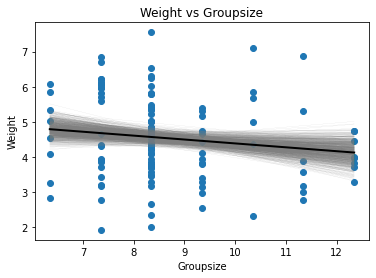

In [195]:
sampling_from_posterior(
    centered_data, mean_groupsize, 
    "weight", "groupsize", 
    posterior_samples, posterior_means,
    "Weight vs Groupsize", "Groupsize", "Weight"
)

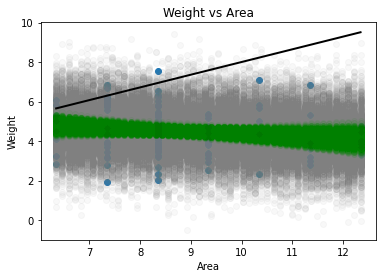

In [198]:
counterfactual_plot(
    centered_data,
    "weight",
    mean_groupsize,
    "groupsize",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples,
    higher_order = True,
    max_order = 1
)

#### 5. Comment on the two regressions

The relationship between the dependent variable `weight` and the covariates `groupsize` and `area` are weakly linear with respective negative and positive relationships. Comparatively, `groupsize` seems to have a relative stronger influence than `area`.

As such, the relationships seems to be highly dependent on our prior belief, as we can achieve a near-flat if not flat (i.e. non existent) relationship by possibly tweaking the prior distribution of the slope $b$.

#### 6. Performing a multivariate model

<u>Running the model:</u>

In [171]:
expr = 'weight ~ area + groupsize'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 4.5
prior_a_sigma = 1.2
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 3.
prior_b_sigma = 1.
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_b2_mean = 4.
prior_b2_sigma = 4.
prior_b2 = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.
sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_b2, prior_sigma]


solution_regression_2var = laplace_solution_regression(expr, data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 189.9135081244328
 hess_inv: array([[ 9.92199353e-02, -2.65089494e-02, -1.78109834e-03,
        -1.01476902e-03],
       [-2.65089494e-02,  2.31226568e-02, -1.14314373e-02,
         1.47008356e-05],
       [-1.78109834e-03, -1.14314373e-02,  9.31247861e-03,
         1.69770554e-04],
       [-1.01476902e-03,  1.47008356e-05,  1.69770554e-04,
         5.28066560e-03]])
      jac: array([ 1.90734863e-06, -7.62939453e-06, -1.90734863e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 197
      nit: 26
     njev: 38
   status: 0
  success: True
        x: array([ 4.36834098,  0.64041406, -0.42976617,  1.11871404])


In [172]:
post_mean, post_sd, posterior_samples_2var = summarize(solution_regression_2var, names={0:'a',1:'b', 2:'b2', 3:'sigma'})

           mean        SD      7.5%     92.5%
a      4.369308  0.301687  3.943376  4.814390
b      0.642323  0.146678  0.429069  0.859670
b2    -0.431277  0.092404 -0.568928 -0.289979
sigma  1.119547  0.071535  1.019571  1.219004


<u>Plotting counterfactual plots:</u>

In [173]:
def counterfactual_plot(
    data: pd.DataFrame,
    depvar_name: str,
    covar_mean: list,
    covar_name: str,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str,
    posterior_samples: np.ndarray,
    higher_order: bool = False,
    max_order: int = 1
):
    """
    
    """
    # Computes the range of the plot area
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = post_mean[0] + post_mean[1] * x_range + post_mean[2] * x_range**2
    mean_prediction = post_mean[0] + \
                      np.sum([post_mean[i] * x_range**(i if higher_order else 1) 
                              for i in range(1, max_order+1)],
                             axis=0)
    # Samples from a posterior distribution to obtain a predictive interval for
    prediction_range = [
        posterior_samples[:,0] + \
        np.sum([posterior_samples[:,i] * _x**(i if higher_order else 1)
        for i in range(1, max_order+1)], axis=0)
        for _x in x_range
    ]
    prediction_range_noise = [
        norm.rvs(prediction, posterior_samples[:,-1]) 
        for prediction in prediction_range
    ]
    # Plots the base of the counterfactual graph
    n = posterior_samples.shape[0]
    plt.plot(x_range + covar_mean, mean_prediction, lw=2, color="black")
    plt.scatter(data[covar_name] + covar_mean, data[depvar_name])
    plt.title(plot_title)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    # Plotting the uncertainty
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, prediction_range_noise[i], alpha = 0.05, color = 'grey')
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, prediction_range[i], alpha = 0.05, color = 'green')

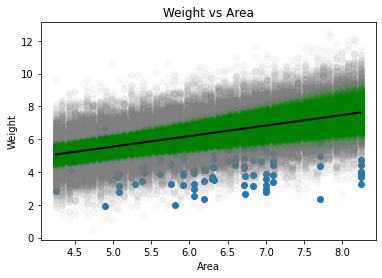

In [202]:
plot_variation(
    data,
    "weight",
    mean_area,
    "area",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples_2var,
    higher_order = False,
    max_order = 1
)

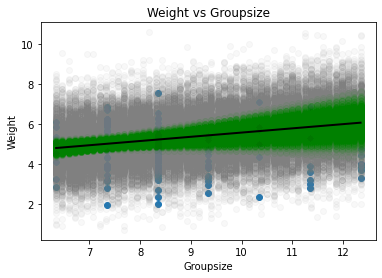

In [204]:
counterfactual_plot(
    data,
    "weight",
    mean_groupsize,
    "groupsize",
    'Weight vs Groupsize',
    "Groupsize",
    "Weight",
    posterior_samples_2var,
    higher_order = False,
    max_order = 2
)

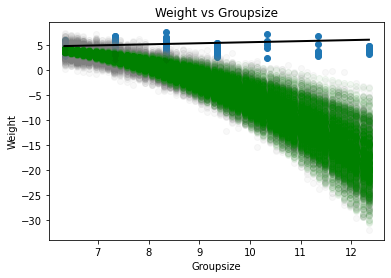

In [174]:
#plotting the average results 
x_range = np.linspace(min(data["groupsize"]), max(data["groupsize"]))
mean_prediction = post_mean[0] + post_mean[1] * x_range + post_mean[2] * x_range

plt.plot(x_range + mean_groupsize, mean_prediction, lw = 2, color = 'black')
plt.scatter(data["groupsize"] + mean_groupsize, data["weight"])
plt.title('Weight vs Groupsize')
plt.ylabel('Weight')
plt.xlabel('Groupsize')

prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range.append(posterior_samples_2var[:500,0] + posterior_samples_2var[:500,1] * x_ + posterior_samples_2var[:500,2] * x_**2)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    pred_mean_data = posterior_samples_2var[:500,0] + posterior_samples_2var[:500,1] * x_ + posterior_samples_2var[:500,2] * x_**2
    prediction_range_noise.append(norm.rvs( pred_mean_data,  posterior_samples_2var[:500,3]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_groupsize, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_groupsize, prediction_range[i], alpha = 0.05, color = 'green')


plt.show()

#### 6. Conclusion

Via the application of the multivariate Laplace approximation method, we see that using both variables `area` and `groupsize` leads to slopes `b1` and `b2` increasing in value (i.e. effect) compared to the models where both variables are used by themselves, separately. 

This indicates that there is a feedback loop between the two variables, affecting the resulting `weight` of urban foxes.

Beyond this, Looking at the plots, we find that many data points fall clearly beyond the confidence interval displayed in our plots when the values of `area` and `groupsize` increases. This might be related to the thinning of the available datapoint as the value increases, which makes our analysis and prediction less robust.

<hr>
<hr>
<hr>

## Exercise 5

Consider the diabetes dataset:

In [29]:
dataset = datasets.load_diabetes(return_X_y=False)
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [30]:
# Define the feature matrix
data = dataset.data

# Define the target
target = dataset.target

### Instructions

Investigate the relationship between age (data[:,0]) and Average blood pressure (data[:,3]). 
By using the WAIC score seen during lesson, can you verify which hypothesis is better supported by the data?

- there is no relationship (constant)
- the relationship is linear
- the relationship is quadratic
- the relationship is cubic
- the relationship is polynomial of order 4

#### 1. Is there a  relationship between the `age` and `bp` variables?

We want to check whether or not there is a relationship between the two variables. If there is none, we can eliminate searching for the other four options.

In [206]:
# Retrieves the age and bp variables as a Pandas DataFrame

data = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
data = data[["age", "bp"]]
data.describe()

,age,bp
count,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.281655e-16
std,4.761905e-02,4.761905e-02
min,-1.072256e-01,-1.123996e-01
25%,-3.729927e-02,-3.665645e-02
50%,5.383060e-03,-5.670611e-03
75%,3.807591e-02,3.564384e-02
max,1.107267e-01,1.320442e-01


[Text(0.5, 1.0, 'Distribution of Ages (Diabetes dataset)')]

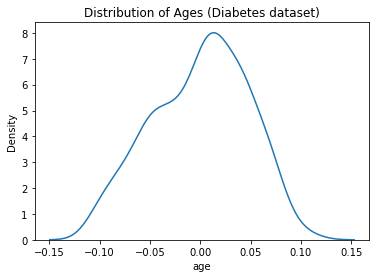

In [207]:
sns.kdeplot(data["age"]).set(title="Distribution of Ages (Diabetes dataset)")

[Text(0.5, 1.0, 'Distribution of Avg. Blood Pressures (Diabetes dataset)')]

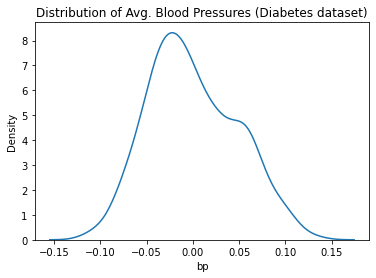

In [208]:
sns.kdeplot(data["bp"]).set(title="Distribution of Avg. Blood Pressures (Diabetes dataset)")

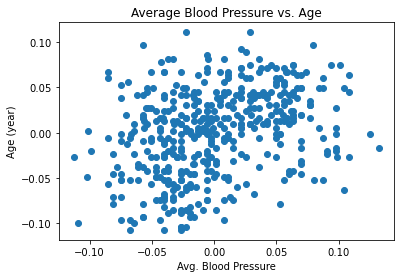

In [209]:
# Plots the relationship between the two variables

plot_relationship(
    data["bp"], data["age"], 
    xlabel="Avg. Blood Pressure", ylabel="Age (year)", 
    title="Average Blood Pressure vs. Age")

<u>Observations:</u>

- The data has been centered 
- There seems to be a somewhat positive relationship between the variables `bp` (average blood pressure) and `age` (this is also informed by general knowledge that blood pressure is usually correlated to age, but this phenomenon will have to be assessed statistically)

<u>Studying the relationship of `age` with `bp`:</u>

Now that we explored in detail the variables `bp` and `age`, we can  study the relationship bwetween the two variable. As such, we are interested in the relationship: 

\begin{align}
\text{age} &= a + b * \text{bp}\\
age &\sim \mathcal{N}(a+c*\text{bp}, \sigma)
\end{align}

The intercept $a$ expresses the `age` of a patient within the Diabetes dataset when the average blood pressure `bp` is null (here in relative terms as the dataset is centered) while the slope $b$ indicates how much the age of a patient changes with their average blood pressure.

To define our Bayesian model, we specify priors for all the parameters we want to analyze. We resort to a standard normal prior for $a$ and $b$ given the centered-ness of the dataset and the support of each variable.

\begin{align}
p(a) &= \mathcal{N}(0, 1)\\
p(b) &= \mathcal{N}(0, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

In [210]:
# Declares the regression expression
expression = "age ~ bp"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 0.; prior_a_sigma = 1.
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0.; prior_b_sigma = 1.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(expression, data, likelihood, priors)

      fun: -742.7998772739726
 hess_inv: array([[ 5.64217996e-06, -3.65666979e-06,  7.03493891e-08],
       [-3.65666979e-06,  1.40339269e-04,  1.06479581e-06],
       [ 7.03493891e-08,  1.06479581e-06,  2.20348715e-06]])
      jac: array([1.67846680e-04, 0.00000000e+00, 2.28881836e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 136
      nit: 28
     njev: 34
   status: 2
  success: False
        x: array([-6.72562670e-09,  3.34754546e-01,  4.48095286e-02])


In [211]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution)

           mean        SD      7.5%     92.5%
a     -0.000085  0.002373 -0.003569  0.003299
b      0.334696  0.011758  0.317520  0.351743
sigma  0.044868  0.001488  0.042719  0.046909


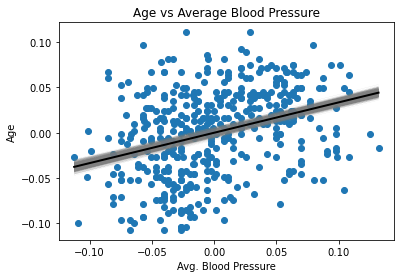

In [212]:
sampling_from_posterior(
    data, 0, 
    "age", "bp", 
    posterior_samples, posterior_means,
    "Age vs Average Blood Pressure", "Avg. Blood Pressure", "Age"
)

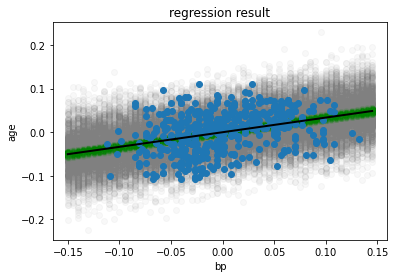

In [216]:
posterior_plot_univariate_regression(solution, np.arange(-0.15,0.15,0.005), data, names = ['bp','age'])

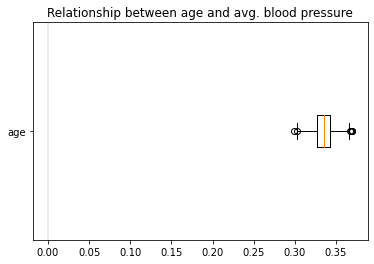

In [217]:
posterior_samples = posterior_sampling_laplace(solution, 1000)

boxes = []
boxes.append(posterior_samples[:,1])

plt.figure()
plt.boxplot(boxes,vert=0)
plt.yticks([1], ['age'])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Relationship between age and avg. blood pressure')
plt.show()

<u>Observations:</u>
    
The posterior mean of the slope $b$ for `bp` is 0.33. Moreover the 85% posterior interval for $b$ is [0.27, 0.40], which lies away from zero. As such, g the strong association of `bp` with the dependent variable `age`, we might conclude that `bp` is a reliable predictor of `age` among the individuals listed in the Diabetes dataset.

#### 2. Application of the WAIC for hypothesis verification

Now that we have settled the observation that there is a positive feedback between the variables `age` and `bp`, we are questioning the kind of relationship it is. We want to test whether the relationship is:

- linear
- quadratic
- cubic
- of order 4

<u>Creating the datasets<u>

In [218]:
data_copy = data.copy()
data_copy['bp2'] = data_copy["bp"] ** 2
data_copy['bp3'] = data_copy["bp"] ** 3
data_copy['bp4'] = data_copy["bp"] ** 4

data_copy.describe()

,age,bp,bp2,bp3,bp4
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.281655e-16,2.262443e-03,3.117309e-05,1.259026e-05
std,4.761905e-02,4.761905e-02,2.736522e-03,3.198483e-04,3.004499e-05
min,-1.072256e-01,-1.123996e-01,4.557233e-09,-1.420020e-03,2.076837e-17
25%,-3.729927e-02,-3.665645e-02,3.076689e-04,-4.925509e-05,9.490351e-08
50%,5.383060e-03,-5.670611e-03,1.270483e-03,-1.823432e-07,1.614127e-06
75%,3.807591e-02,3.564384e-02,3.284857e-03,4.528490e-05,1.079028e-05
max,1.107267e-01,1.320442e-01,1.743568e-02,2.302280e-03,3.040028e-04


In [219]:
quadratic_expression = "age ~ bp + bp2"
cubic_expression = "age ~ bp + bp2 + bp3"
order4_expression = "age ~ bp + bp2 + bp3 + bp4"

In [ ]:
S = 5000

lppd = []
p_waic = []

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b1_mean = 0
prior_b1_sigma = 1
prior_b1 = ['gaussian', [prior_b1_mean, prior_b1_sigma]]

prior_b2_mean = 0
prior_b2_sigma = 1
prior_b2 = ['gaussian', [prior_b2_mean, prior_b2_sigma]]

sigma_inf = 0
sigma_sup = 2
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b1, prior_b2, prior_sigma]

solution_quadratic = laplace_solution_regression(quadratic_expression, data_copy, likelihood, priors)
posterior_samples = posterior_sampling_laplace(solution_quadratic, S)
    
for t, target in enumerate(data["age"]):
    log_p = []
    for l in range(S):
        pred = posterior_samples[l,0] + posterior_samples[l,1]*data_copy["bp"][t] + \
               posterior_samples[l,2]*data_copy["bp2"][t]
        log_p.append(norm.logpdf(target, loc=pred, scale=posterior_samples[l,-1]))

    lppd.append(logsumexp(log_p) - np.log(len(log_p)))
    p_waic.append(np.var(log_p))

waic_vect_model1 = -2*(np.array(lppd) - np.array(p_waic))
waic_model1 = -2*(np.sum(lppd) - np.sum(p_waic))
p_waic_model1 = np.sum(p_waic)
se_model1 = np.sqrt(len(data_copy["age"])*np.var(waic_vect_model1))

print(waic_model1)
print(p_waic_model1)
print(se_model1)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -742.6203179456484
 hess_inv: array([[ 1.64685201e-05,  4.90637583e-05,  3.27589546e-05,
        -1.09764527e-05],
       [ 4.90637583e-05,  9.94427312e-04,  7.27038311e-05,
        -4.83471008e-05],
       [ 3.27589546e-05,  7.27038311e-05,  1.62012947e-04,
        -2.97985152e-05],
       [-1.09764527e-05, -4.83471008e-05, -2.97985152e-05,
         1.17649727e-05]])
      jac: array([-2.67028809e-04, -7.62939453e-06, -7.62939453e-06,  5.34057617e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 262
      nit: 32
     njev: 52
   status: 2
  success: False
        x: array([ 0.0017231 ,  0.3452307 , -0.76161841,  0.04470493])


<hr>
<hr>
<hr>

## Exercise 6

Which model would you support between the following:

- target depends on _Age_
- target depends on _Age_ and _Sex_
- target depends on _Age_ and _Body mass index_ 
- target depends on _Age_ and _Body mass index_ and _Average blood pressure_
- target depends on _Age_ and _Sex_ and _Body mass index_ 
- target depends on _Age_ and _Sex_ and _Body mass index_ and _Average blood pressure_
- target depends on  _Body mass index_ and _Average blood pressure_

